In [1]:
from tools import datacleaner as dtclean
from tools import dataexplore as dtexp
from view import data_visualization as dtview
import pandas as pd
import numpy as np
from fbprophet import Prophet
from evaluation import forecast_metrics as fm
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings

warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# Obtendo o dataframe

In [2]:
df_274_time_clients = dtclean.get_Dataframes_time(274,'c')
df_274_time_clients.reset_index(inplace=True)
df_274_clients = dtclean.get_Dataframes(274,'c')
df_274_clients.reset_index(inplace=True)

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [3]:
iplot(dtview.plot_scatter(df_274_time_clients,title='Quantidade de clientes/hora'))

<div class="alert alert-block alert-info">
<b>Obs:</b> Notamos nesse gráfico que há um pico de clientes no mês de março e uma queda significativa no fim
do mês de maio. Na celula abaixo criamos um modelo sem promover afinamentos para efeitos de comparação.
</div>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


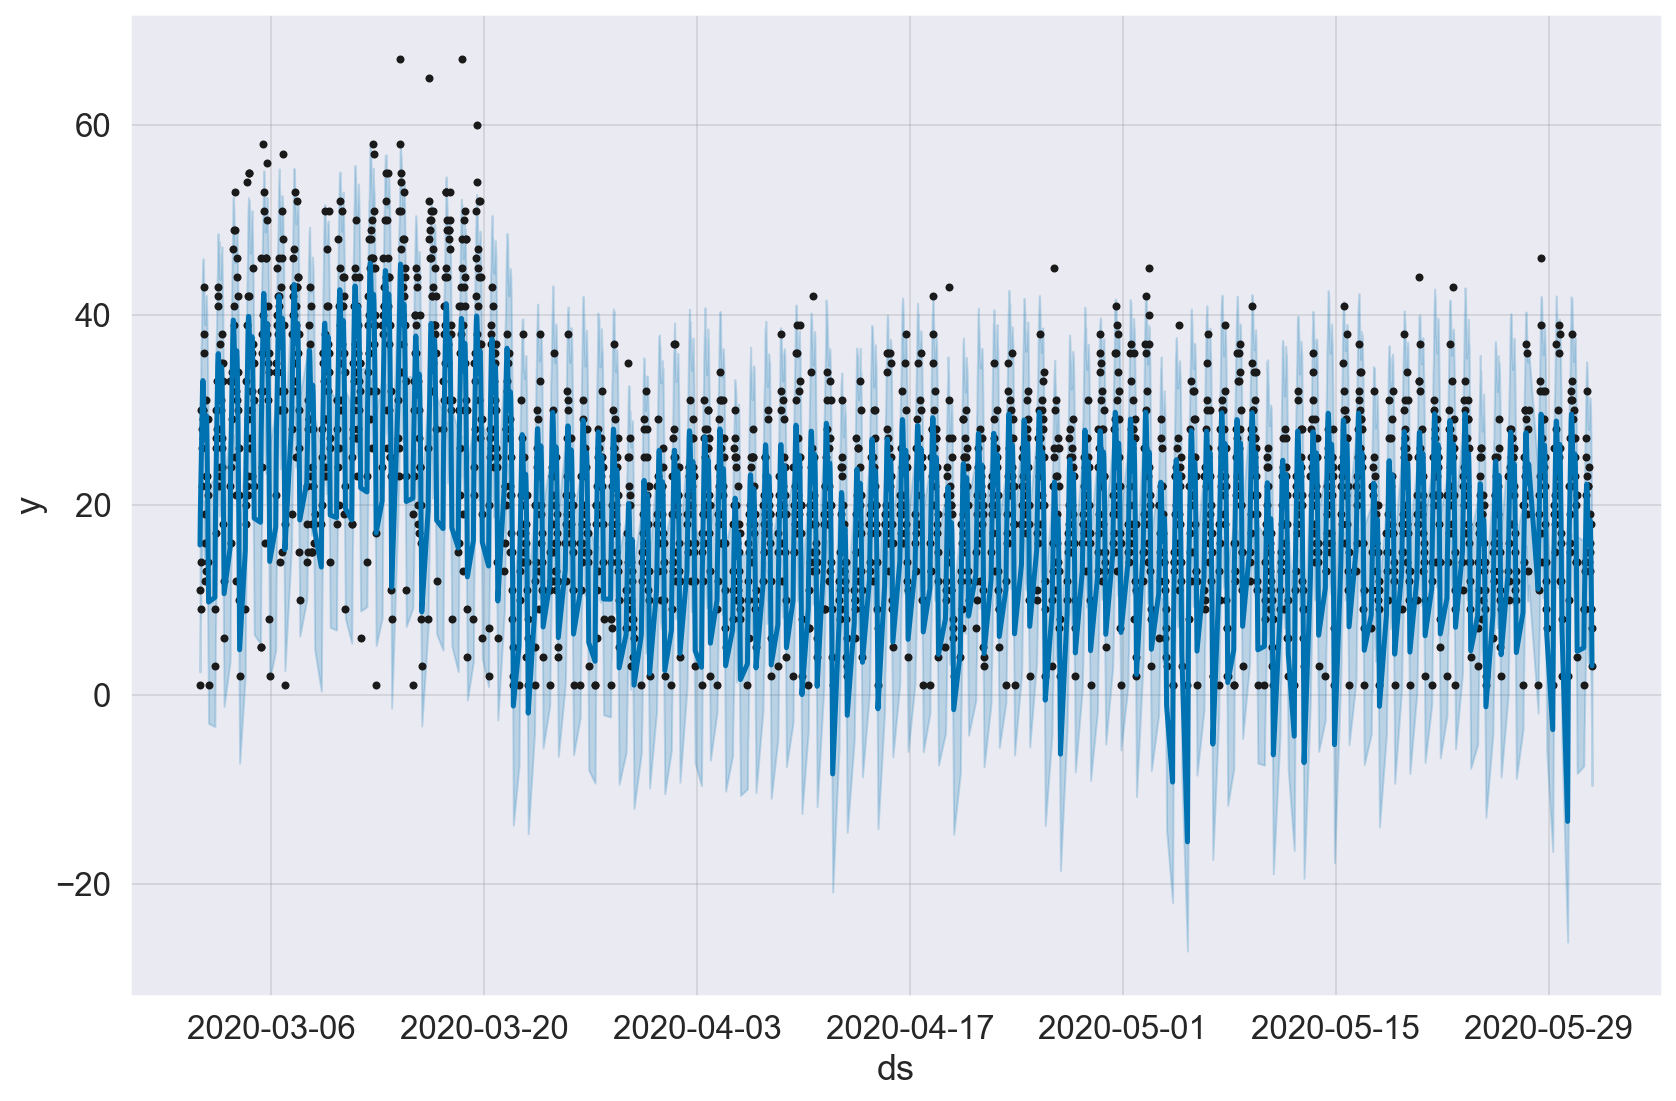

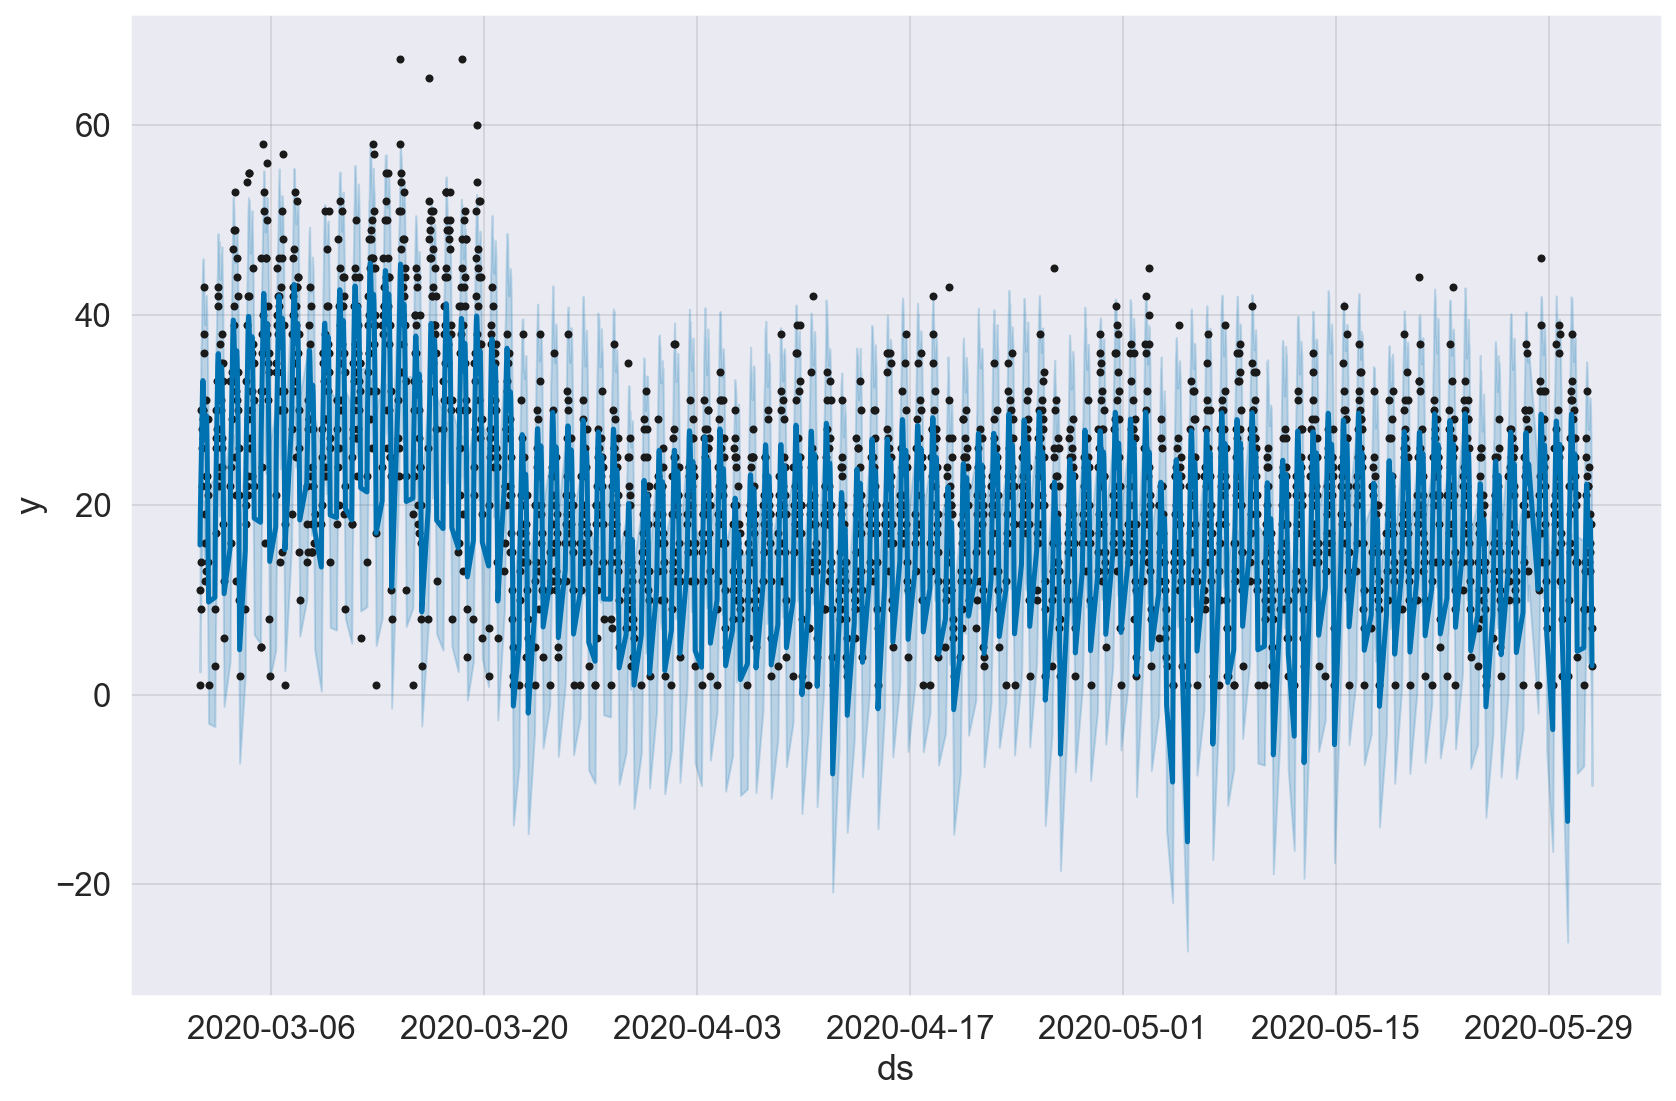

In [4]:
model = Prophet(interval_width=0.95)
model.fit(df_274_time_clients)
forecast = model.predict(df_274_time_clients)
model.plot(forecast,figsize=(12,8))


# Análise dos Dados

<div class="alert alert-block alert-warning">
<b>Obs:</b> Na análise dos dados identificamos incosistências que podem comprometer a performance dos modelos
gerados nesse trabalho. Para mitigar esse impacto foram feitas análises sobre os dados agregados ao dia e por hora.
Esse notebook inicia a apresentação dos dados agregados por hora.
</div>

In [5]:
iplot(dtview.plot_scatter(df_274_time_clients,title='Clientes/hora (março-maio de 2020)'))

In [6]:
df_new = dtexp.date_features(df_274_time_clients)
mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
semanaAgregada = pd.DataFrame(df_new.groupby("num")["y"].sum()).reset_index().sort_values('num')
iplot(dtview.plot_dados_agregados_semana_mes(mesAgregado,tipo_agregacao='m',xaxes_title='Nº da semana',yaxis_title='Total de clientes',
                                      title='Clientes por Semana', hover='31/05',is_client_df=True))
iplot(dtview.plot_dados_agregados_semana_mes(semanaAgregada,xaxes_title='Nº do dia (0 = Domingo, 1 = Segunda ...)',yaxis_title='Total de clientes',
                                      title='Clientes por dia'))

<div class="alert alert-block alert-info">
<b>Clientes por Semana:</b> Mensalmente há, conforme já observado, um pico de clientes entre a 9ª e a 11ª semana de 2020,
que corresponde ao período de 24 de fevereiro à 15 de março, contudo nossos dados começam em 01 de março.
Destaca-se a última semana (22ª) como a de menor volume de clientes.
<p><b>Vendas por Dia:</b> Na quantidade diária de clientes nota-se que há um aumento crescente com domingo sendo o dia
com menor número de clientes na loja e esse número aumenta gradualmente a cada dia, atingindo o pico na quinta-feira.</p>
</div>

In [7]:
df_274_clients_treino, df_274_clients_teste = dtexp.configura_dataframe_treino_teste(df_274_time_clients)
periods=df_274_clients_teste.shape[0]

# Visualizando o montante de dados para os datasets de treino e de teste

In [8]:
iplot(dtview.compare_dataframes_with_scatter(df_274_clients_treino,
                                   df_274_clients_teste,
                                   title='Montante de dados de clientes de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [9]:
prophet = Prophet()
prophet.fit(df_274_clients_treino)
future_clientes = prophet.make_future_dataframe(periods=periods, freq='30min')
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_clientes['ds'] = pd.to_datetime(future_clientes['ds'])
future_clientes = future_clientes.set_index(pd.DatetimeIndex(future_clientes['ds']))
future_clientes = future_clientes.between_time('10:00','16:00')
forecast_clientes = prophet.predict(future_clientes)
forecast_clientes = dtclean.remove_negative_values(forecast_clientes)
#forecast_clientes.to_csv('forecast_clientes.csv')
iplot(dtview.plot_forecast_as_table(forecast_clientes))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Visualizando os componentes da série temporal

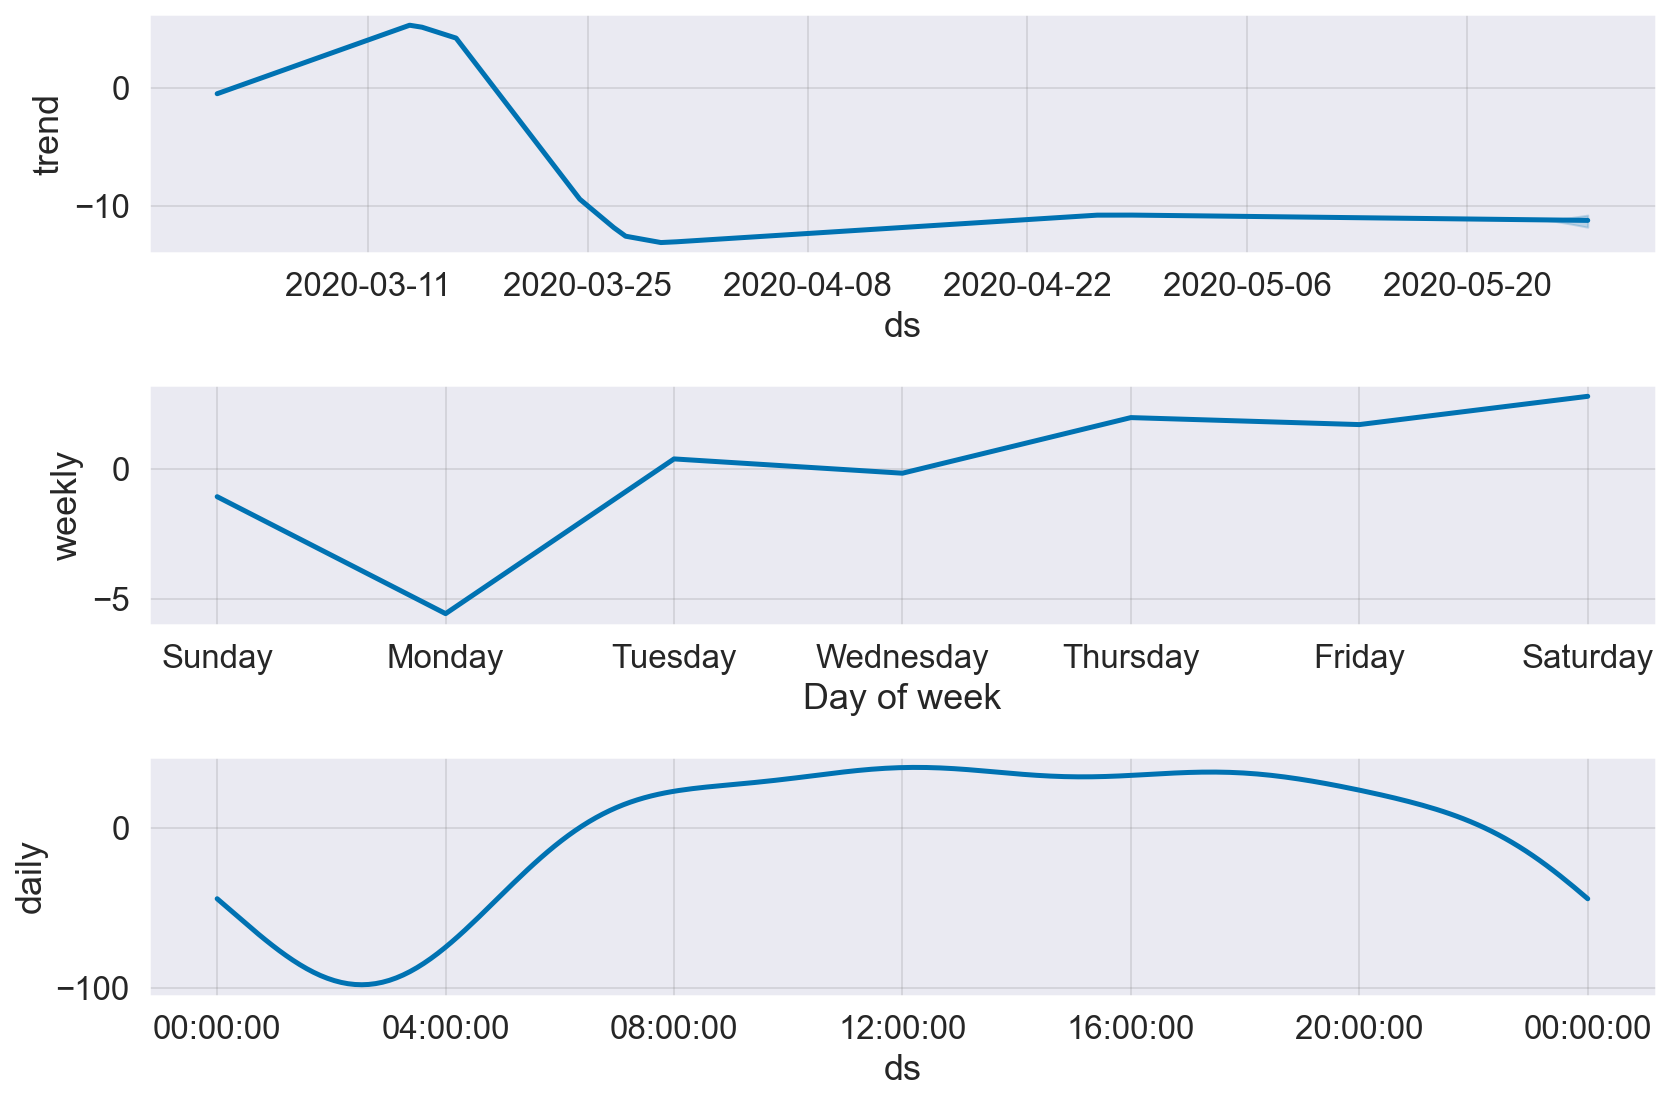

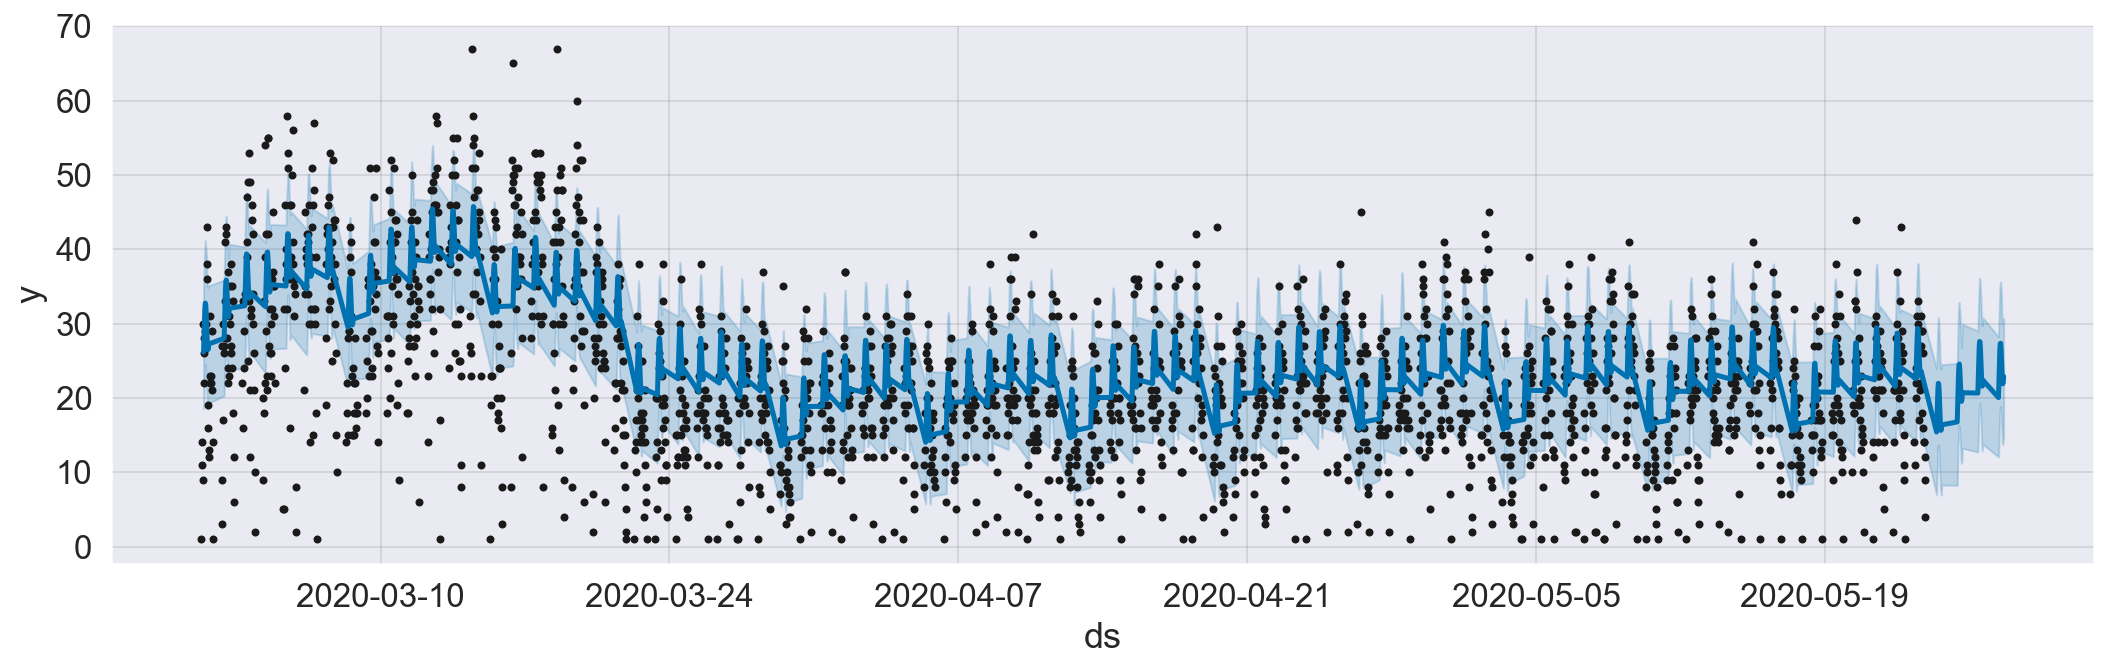

In [10]:
fig = prophet.plot_components(forecast_clientes, figsize=(12,8))

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_clientes,ax=ax)
plt.show()

In [18]:
df_274_clients_teste_n = df_274_clients_teste.copy()
df_274_clients_teste_n['ds'] = pd.to_datetime(df_274_clients_teste_n['ds'])
df_274_clients_teste_n = df_274_clients_teste_n.set_index(pd.DatetimeIndex(df_274_clients_teste_n['ds']))
df_274_clients_teste_n = df_274_clients_teste_n.between_time('10:00','16:00')

In [19]:
df_274_clients_teste_forecast = prophet.predict(df_274_clients_teste_n)
df_274_clients_teste_forecast=dtclean.remove_negative_values(df_274_clients_teste_forecast)

# Visualizando a previsão

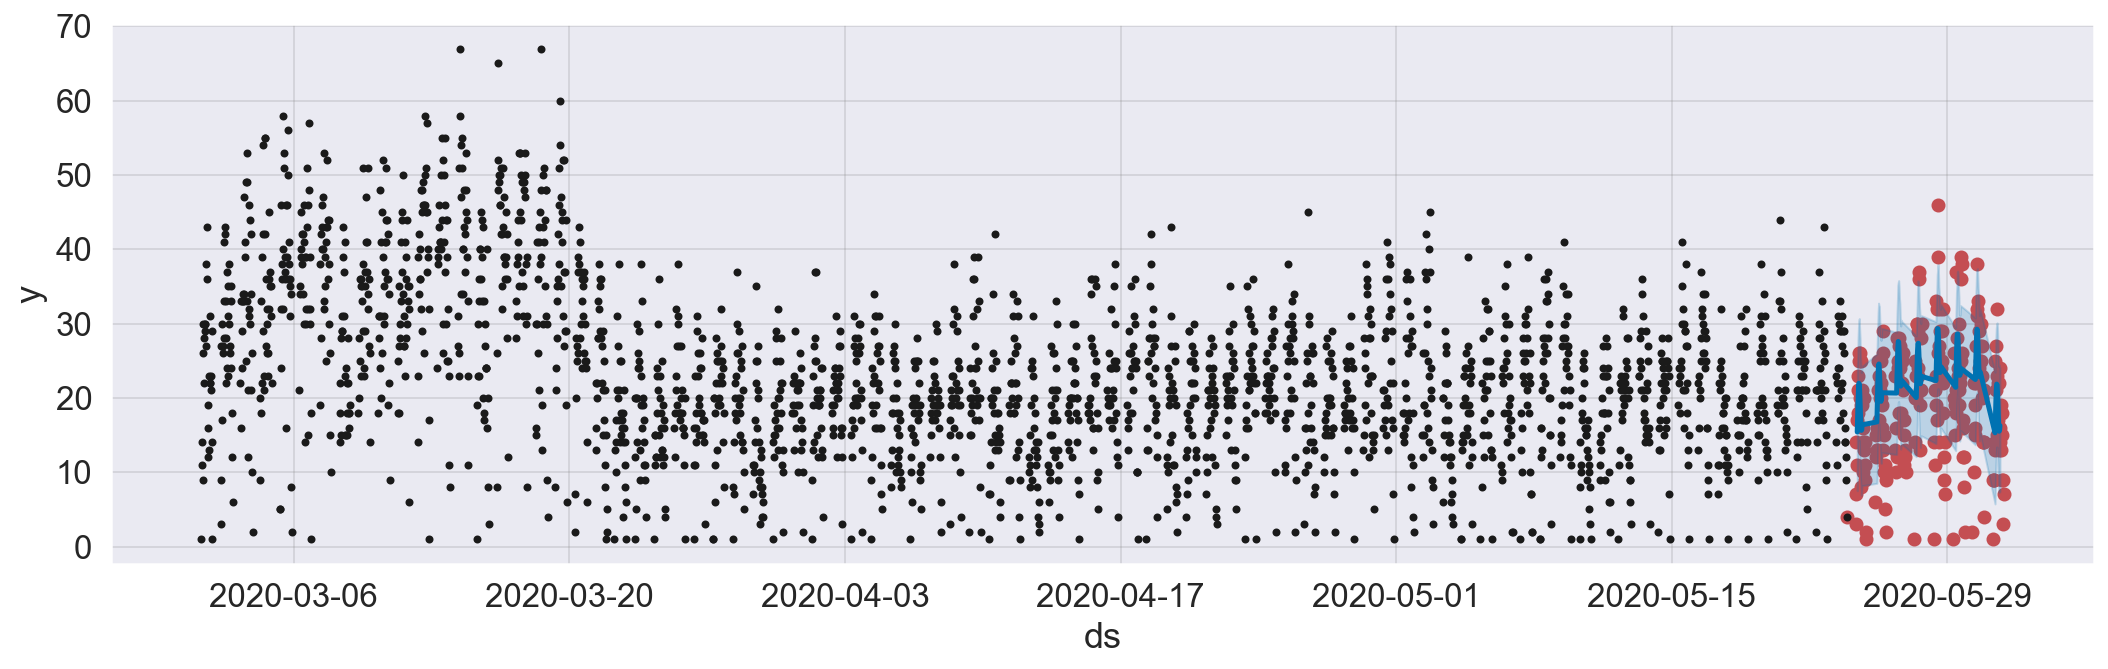

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste.ds,df_274_clients_teste['y'], color='r')
fig = prophet.plot(df_274_clients_teste_forecast,ax=ax)
plt.show()


# Comparação entre a quantidade de clientes previstos e quantidade real

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(df_274_clients_teste,
                                   df_274_clients_teste_forecast,
                                   title='Previsão da quantidade de clientes vs quantidade real',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [13]:
# Visualizando a previsão e os dados originais
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste.ds, df_274_clients_teste['y'], color='r')
fig = prophet.plot(df_274_clients_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 100)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

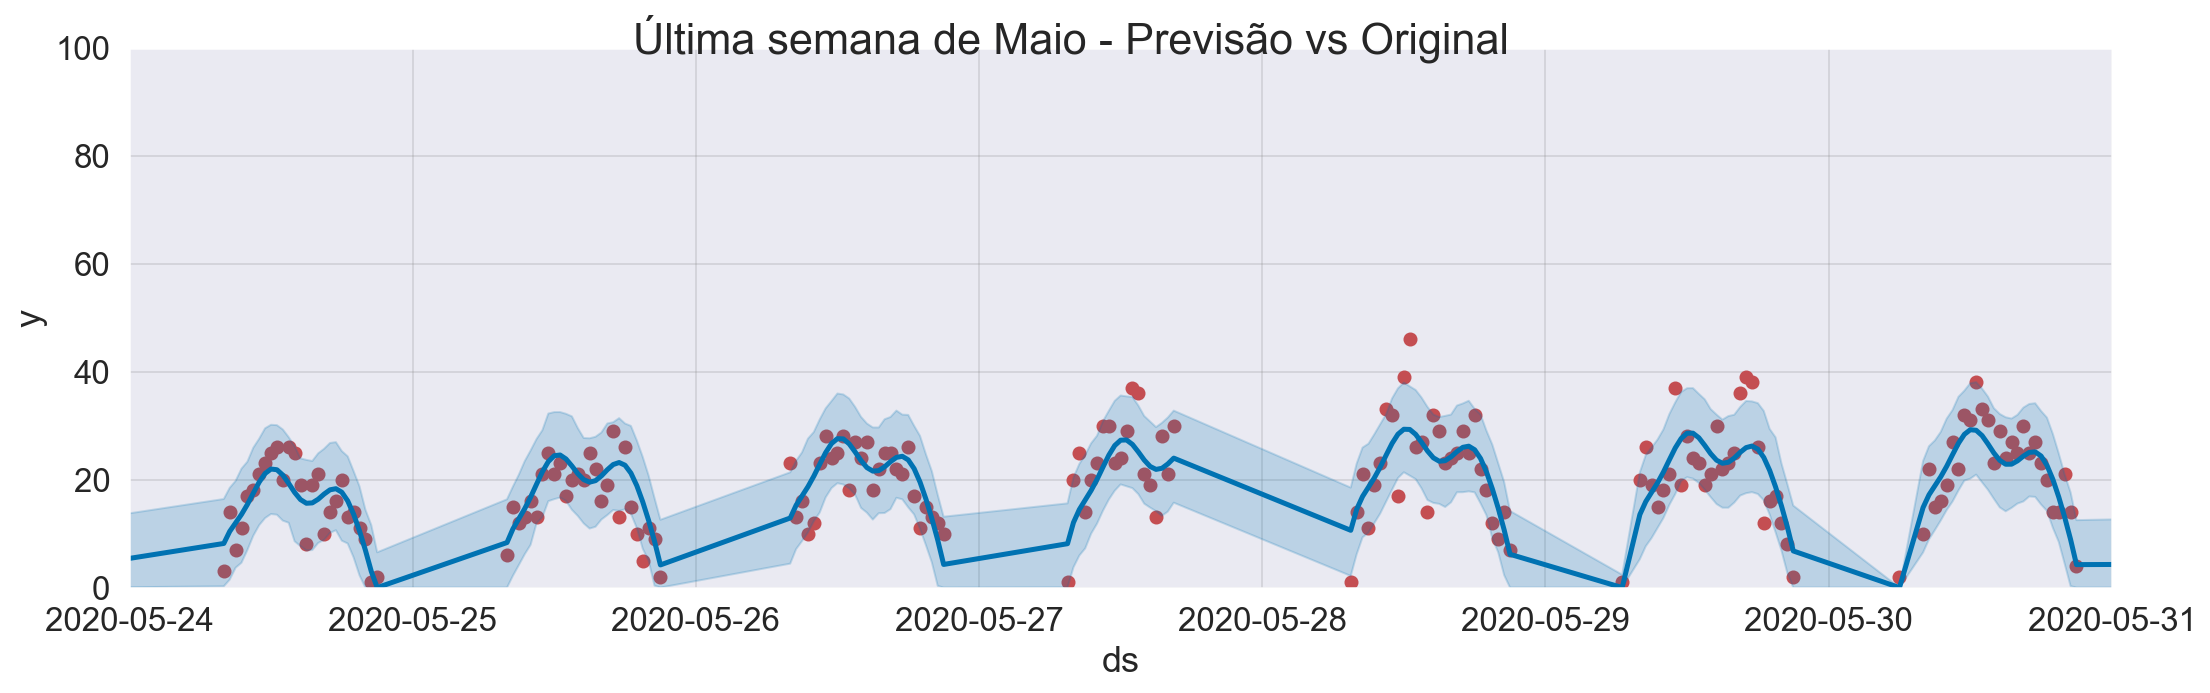

In [14]:
# Visualizando a previsão e os dados originais
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste.ds, df_274_clients_teste['y'], color='r')
fig = prophet.plot(df_274_clients_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 100)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [15]:
print("MAPE ------> {}".format(fm.mape(np.array(df_274_clients_teste['y']),
                                                    np.array(df_274_clients_teste_forecast['yhat']))))


MAPE ------> 0.36810083250277376


In [16]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_clients_teste,
    df_274_clients_teste_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))

# Criando novo modelo com os feriados

In [17]:
prophet_feriados = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_clients_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em horas (os dados estão em horas)
future_feriados = prophet_feriados.make_future_dataframe(freq='30min', periods=periods)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_feriados['ds'] = pd.to_datetime(future_feriados['ds'])
future_feriados = future_feriados.set_index(pd.DatetimeIndex(future_feriados['ds']))
future_feriados = future_feriados.between_time('08:00','21:00')
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)
forecast_feriados = dtclean.remove_negative_values(forecast_feriados)
iplot(dtview.plot_forecast_as_table(forecast_feriados))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


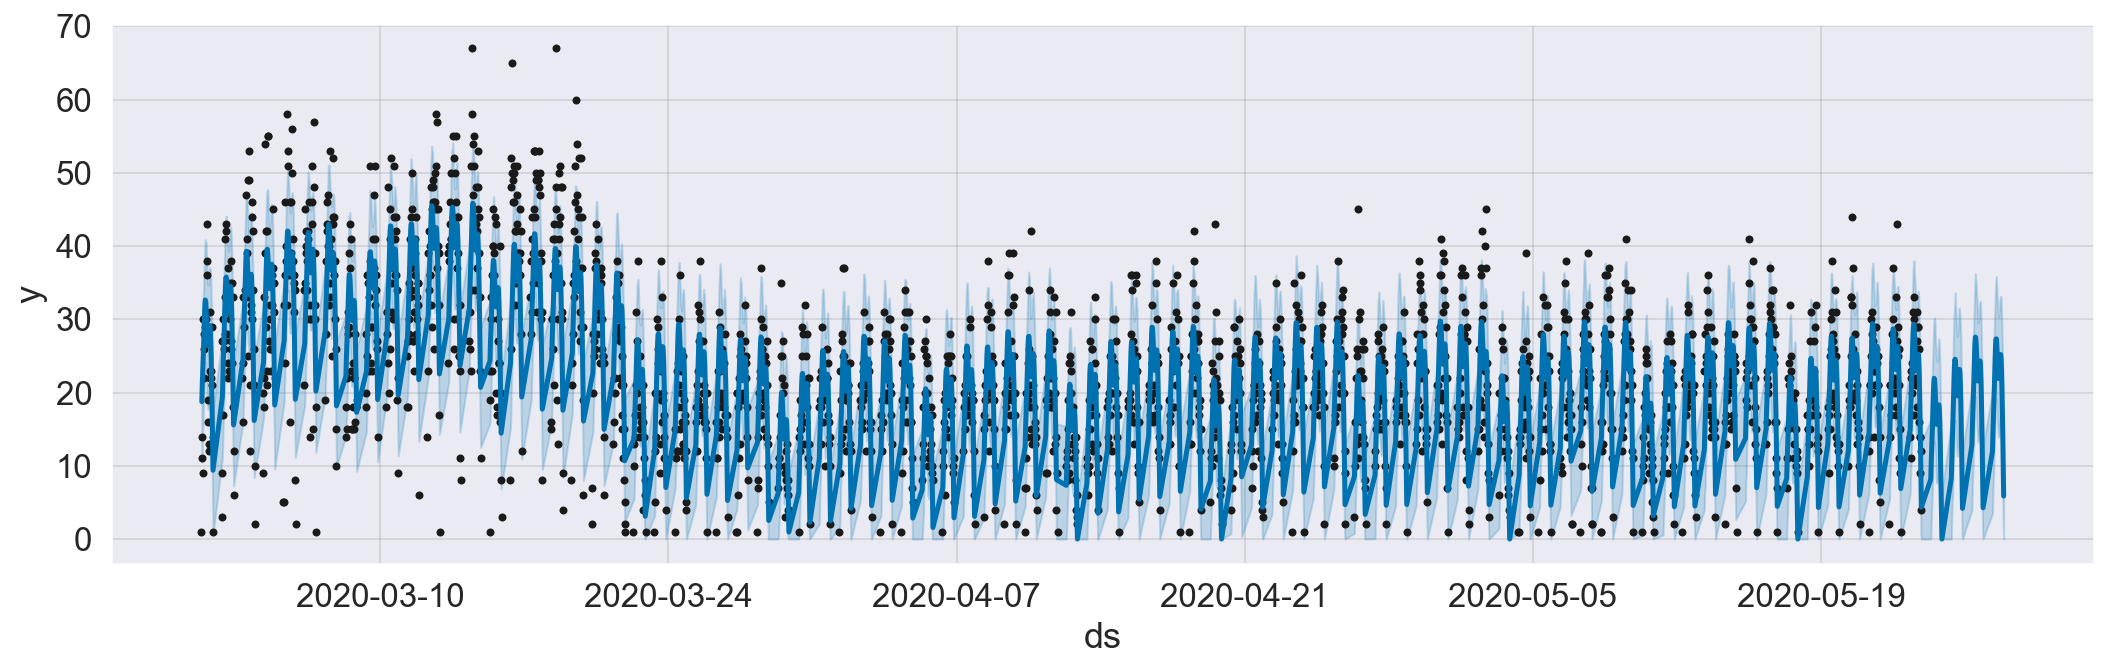

In [18]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()


## Visualizar dataframe de teste previsto e original com feriados

In [19]:
forecast_teste_feriados = prophet_feriados.predict(df_274_clients_teste)
forecast_teste_feriados = dtclean.remove_negative_values(forecast_teste_feriados)

iplot(dtview.compare_dataframes_with_scatter(
    df_274_clients_teste,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [20]:
mape_com_feriados = fm.mape(np.array(df_274_clients_teste.y),np.array(forecast_teste_feriados.yhat))
print("MAPE",mape_com_feriados)

MAPE 0.36755197345935653


# FIM ANALISE POR HORA

# **Análise dos dados de clientes agupados ao dia (loja 274)**

In [21]:
# Análise de clientes agrupadas ao dia

iplot(dtview.plot_scatter(df_274_clients,title='Quantidade de clientes'))


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


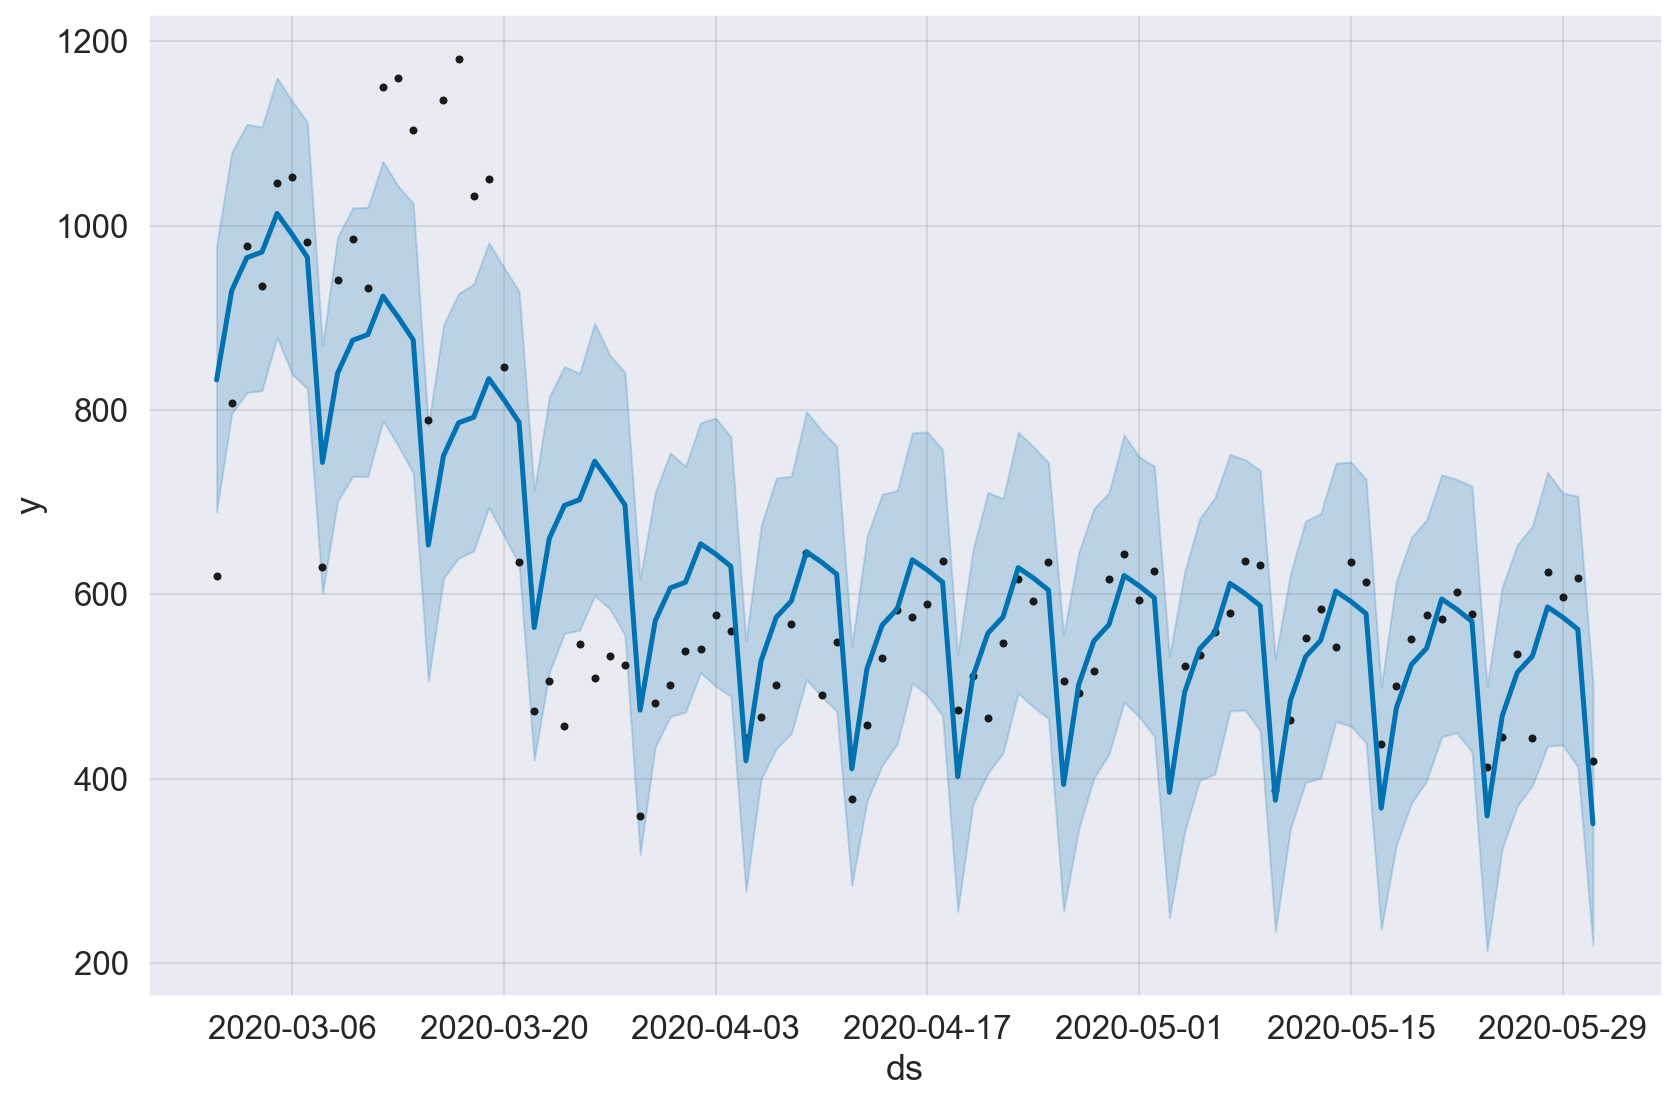

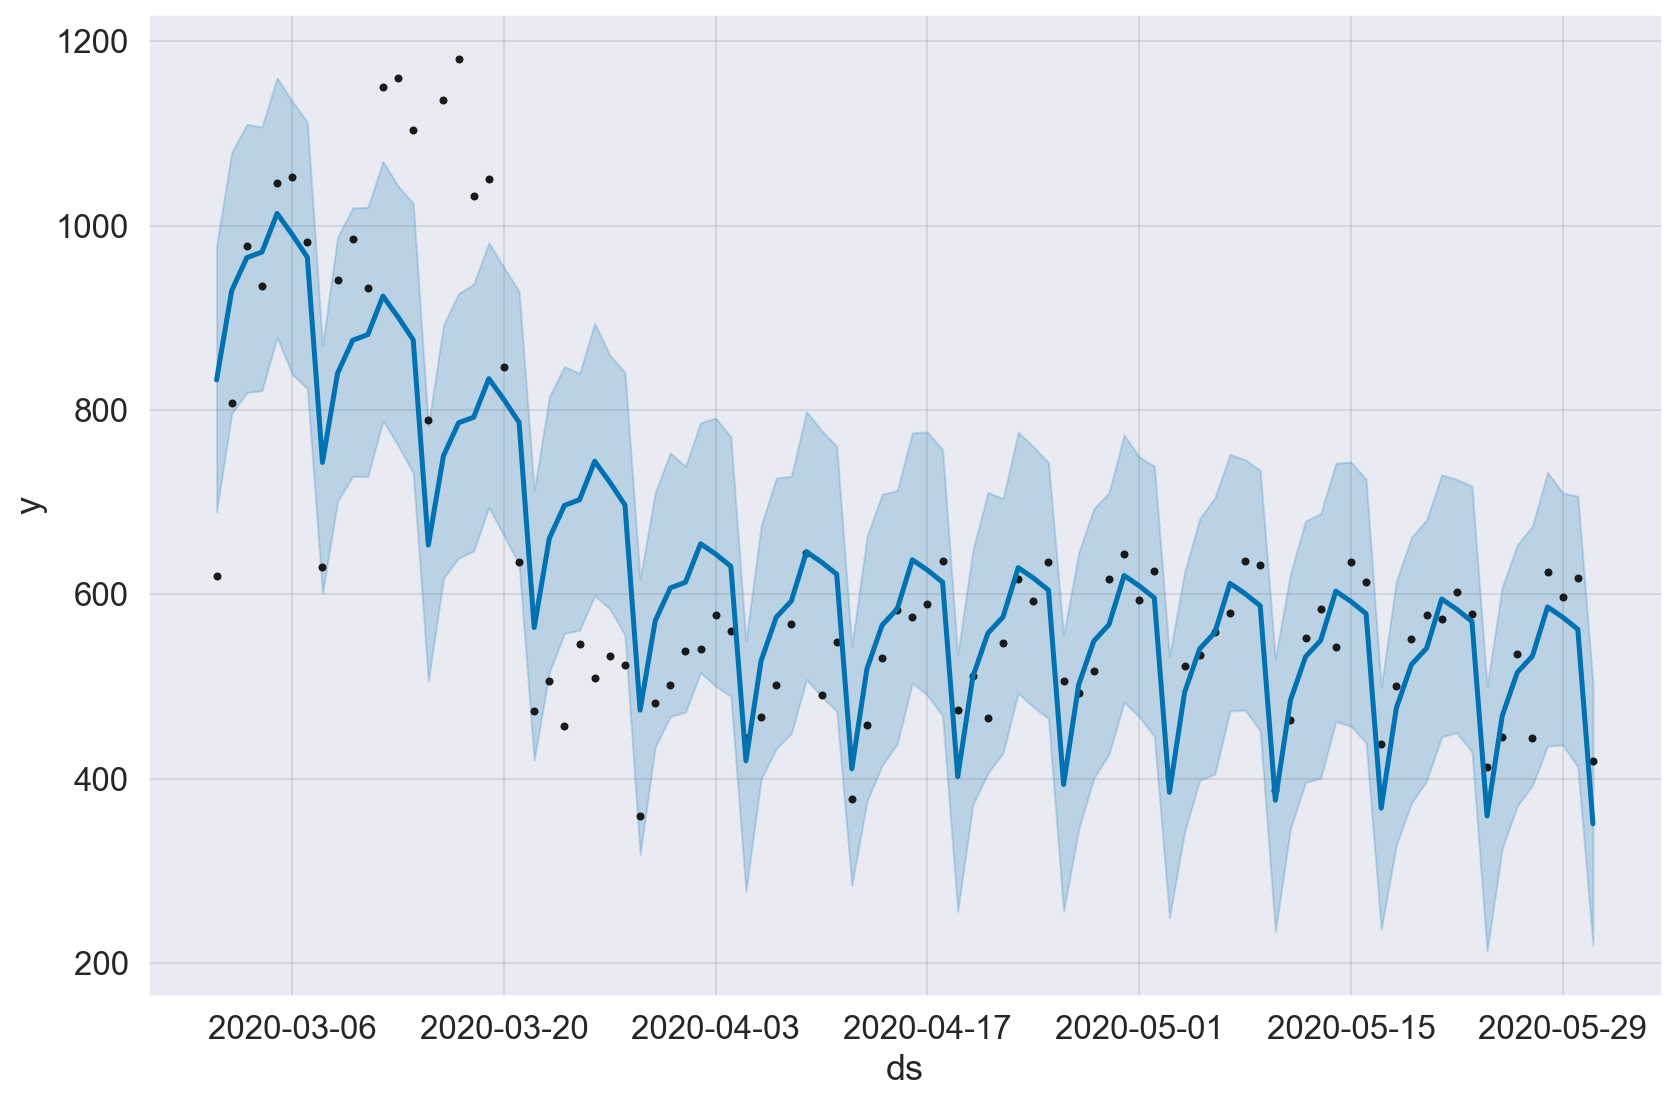

In [22]:
model = Prophet()
model.fit(df_274_clients)
forecast = model.predict(df_274_clients)
model.plot(forecast,figsize=(12,8))

In [23]:
df_274_clients_treino_diario, df_274_clients_teste_diario = dtexp.configura_dataframe_treino_teste(df_274_clients)

## Visualizando a representação dos datasets de treino e de teste sobre o montante total.

In [24]:
iplot(dtview.compare_dataframes_with_scatter(df_274_clients_treino_diario,
                                   df_274_clients_teste_diario,
                                   title='Montante de dados de clientes de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [ ]:
prophet = Prophet()
prophet.fit(df_274_clients_treino_diario)
future_clientes = prophet.make_future_dataframe(periods=7, freq='D')
forecast_clientes = prophet.predict(future_clientes)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
fig = prophet.plot_components(forecast_clientes, figsize=(12,8))


# Modelo Baseado na Decomposição dos Componentes

<div class="alert alert-block alert-info">
<b>Tendência:</b> Os dados apresentam uma tendência de queda inicial com aumento gradual da quantidade de clientes.
<p><b>Componente Semanal:</b> Nesse componente observamos um volume negativo de clientes entre domingo e quarta.
Isso ocorre em função da sazonalidade semanal e diária que ainda não foi identificada corretamente e as grandes
variações nas quantidades de clientes entre os meses de março e os seguintes. Esses fatores podem ser os que
apresentam maior influência nesses resultados. Notamos que a quarta-feira, no modelo previsto, mantém o comportamento
identificado anteriormente nos dados reais.</p>
</div>

In [ ]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_clientes,ax=ax)
plt.show()

<div class="alert alert-block alert-info">
<b>Gráfico do modelo previsto:</b> Os pontos escuros no gráfico representam os dados reais e na altura da segunda semana
de março, observamos dados que escapam do modelo previsto indicando possíveis outliers. As linhas azuis mais escura,
representam a previsão de quantidade de clientes enquanto as linhas mais claras representam o intervalo de
confiança em torno da previsão.
</div>

In [ ]:
df_274_clients_teste_diario_forecast = prophet.predict(df_274_clients_teste_diario)

In [ ]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste_diario.ds,df_274_clients_teste_diario['y'], color='r')
fig = prophet.plot(df_274_clients_teste_diario_forecast,ax=ax)
plt.show()


# Comparação entre as clientes do dataset previsto e as clientes do dataset de teste (quantidade real de clientes)

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(df_274_clients_teste_diario,
                                   df_274_clients_teste_diario_forecast,
                                   title='Previsão do número de clientes vs quantidade real de clientes',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste_diario.ds, df_274_clients_teste_diario['y'], color='r')
fig = prophet.plot(df_274_clients_teste_diario_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 900)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [ ]:
mape_analysis = []
mape_analysis.append(fm.mape(np.array(df_274_clients_teste_diario['y']),
                                       np.array(df_274_clients_teste_diario_forecast['yhat'])))
print("MAPE ------> {}".format(mape_analysis[0]))


In [ ]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_clients_teste_diario,
    df_274_clients_teste_diario_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))

# Criando novo modelo com os feriados

<div class="alert alert-block alert-info">
<b>Adicionando feriados ao modelo:</b> Vamos verificar se há melhora no MAPE com os feriados adicionados ao novo modelo.
</div>

In [ ]:
prophet_feriados = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_clients_treino_diario)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)

In [ ]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()

<div class="alert alert-block alert-info">
Visualmente não notamos grandes diferenças no gráfico previsto para o novo modelo gerado com feriados. Cabe destacar
que não sabemos os feriados específicos da cidade e sequer eventos que possam impactar na variável em análise, como
dias de jogos de futebol, eventos festivos e etc.
</div>

# Visualizando os componentes do modelo

In [ ]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados, figsize=(12,8))

<div class="alert alert-block alert-info">
<b>Componentes:</b> Também não há diferenças nos gráficos de componentes de tendência e semanal, apenas há um novo
componente que representa o feriado onde se espera que não haja clientes nesses dias, contudo, isso pode representar
exatamente o oposto, isto é, a loja funciona nos feriados e há um volume de clientes razoável nos dias que antecedem
o feriado, é preciso saber essas informações para adaptar o modelo.
</div>

In [ ]:
forecast_teste_feriados = prophet_feriados.predict(df_274_clients_teste_diario)

## Visualizar dataframe de teste previsto e original com feriados

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_clients_teste_diario,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [ ]:
mape_analysis.append(fm.mape(np.array(df_274_clients_teste_diario.y), np.array(forecast_teste_feriados.yhat)))
print("MAPE ------> {}".format(mape_analysis[1]))

<div class="alert alert-block alert-info">
Conforme podemos verificar pelo resultado do MAPE, a adição dos feriados não ocasionou impactos dignos de nota.
</div>

# Identificando os outliers

In [ ]:
dtview.check_outliers_univariate(df_274_clients)

In [ ]:
df_sem_outliers = df_274_clients[df_274_clients['y'] < 847]

In [ ]:
df_274_sem_outliers_treino, df_274_sem_outliers_teste = dtexp.configura_dataframe_treino_teste(df_sem_outliers)

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_treino,
                                   df_274_sem_outliers_teste,
                                   title='Montante de dados de clientes de Treinamento e Teste (sem outliers)',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [ ]:
prophet_no_outliers = Prophet()
prophet_no_outliers.fit(df_274_sem_outliers_treino)
future_no_outliers = prophet_no_outliers.make_future_dataframe(periods=7, freq='D')
forecast_no_outliers = prophet_no_outliers.predict(future_no_outliers)

iplot(dtview.plot_forecast_as_table(forecast_no_outliers))

In [ ]:
# Visualizando os componentes

fig = prophet_no_outliers.plot_components(forecast_no_outliers, figsize=(12,8))


In [ ]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_no_outliers.plot(forecast_no_outliers,ax=ax)
plt.show()

In [ ]:
df_274_no_outliers_teste_forecast = prophet_no_outliers.predict(df_274_sem_outliers_teste)

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_274_no_outliers_teste_forecast,
                                   title='Previsão da quantiade de clientes vs quantidade real de clientes',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [ ]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds,df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast,ax=ax)
plt.show()

## Comparando os dados previsto com os realizados

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds, df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 900)
plot = plt.suptitle('Primeira semana de Maio - Previsão vs Original')

In [ ]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

In [ ]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste.y),
                               np.array(df_274_no_outliers_teste_forecast.yhat)))
print("MAPE -----> {}".format(mape_analysis[2]))


In [ ]:
prophet_feriados_s_outliers = Prophet(holidays=dtclean.get_Holiday())

prophet_feriados_s_outliers.add_country_holidays('BR')
prophet_feriados_s_outliers.fit(df_274_sem_outliers_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados_s_outliers = prophet_feriados_s_outliers.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)
# Previsão optimizada dos valores
future_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)

In [ ]:
plt,fig_forecast_feriado_s_outliers = dtview.plot_forecast(future_feriados_s_outliers,prophet_feriados_s_outliers,f,ax)
plt.show()

# Visualizando os componentes do modelo

In [ ]:
fig_forecast_feriado_s_outliers = prophet_feriados_s_outliers.plot_components(forecast_feriados_s_outliers,figsize=(12,8))

In [ ]:
forecast_teste_feriados_s_outliers = prophet_feriados_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(forecast_teste_feriados_s_outliers))

# Visualizar dataframe de teste previsto e original com feriados

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sem_outliers_teste,
    forecast_teste_feriados_s_outliers,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [ ]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        forecast_teste_feriados_s_outliers,
        nametrace1='Original',
        nametrace2='Previsão com feriados',
        idx_end=28))

In [ ]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(forecast_teste_feriados_s_outliers['yhat'])))
print("MAPE -----> {}".format(mape_analysis[3]))


# Configurando e treinando o modelo com feriados e parâmetros otimizados

In [ ]:
final_prophet_s_outliers = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet_s_outliers.add_country_holidays(country_name='BR')
final_prophet_s_outliers.fit(df_274_sem_outliers_treino)

In [ ]:
future_final_s_outliers = final_prophet_s_outliers.make_future_dataframe(periods=7, freq='D')
forecast_final_s_outliers = final_prophet_s_outliers.predict(future_final_s_outliers)
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

In [ ]:
# Visualizando os componentes do modelo
fig = final_prophet_s_outliers.plot_components(forecast_final_s_outliers, figsize=(12,10))

In [ ]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet_s_outliers.plot(forecast_final_s_outliers,ax=ax)
plt.show()

In [ ]:
df_teste_final_s_outliers= final_prophet_s_outliers.predict(df_274_sem_outliers_teste)


## Comparando os dados previstos com os realizados

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_teste_final_s_outliers,
                                   title='Previsão de clientes vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [ ]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sem_outliers_teste,
    df_teste_final_s_outliers,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [ ]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(df_teste_final_s_outliers['yhat'])))

print("MAPE -----> {}".format(mape_analysis[4]))

In [ ]:
mape_keys = ['inicial','feriados','outliers','outliers feriados','outliers params']
mape_clientes_diarias = dict(zip(mape_keys,mape_analysis))
iplot(dtview.plot_results(
    list(mape_clientes_diarias.keys()),
    list(mape_clientes_diarias.values()),
    title='Evolução da métrica MAPE'))